<a href="https://colab.research.google.com/github/LIYunzhe1408/Flow-Matching/blob/main/cs180_proj5b_flowmatching_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5B: Flow Matching from Scratch!

## Setup environment

In [64]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [65]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import torch.nn.functional as F

# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

UNet covers both semantic concepts and specific details. When downsampling, we are going deep into the high-level concept, while upsampling is converting abstract concept back to image with high resolution. When up sampling, previous downsampled features will be concatenated together to cover both details(edge from downsampling) and semantic(from upsampling)

In [129]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.upconv(x)))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.pool(x)).view(x.size(0), -1)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1, 1, 1)
        return self.activate(self.bn(self.convTrans(x)))

In [130]:

# Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        return self.conv2(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downConv = DownConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downConv(x)
        return self.conv_block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        return self.conv_block(x)

## Implementing Unconditional UNet

In [154]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.initial_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens)  # 28x28 -> 14x14
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)  # 14x14 -> 7x7

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2, num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)  # 7x7 -> 14x14
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)  # 14x14 -> 28x28
        self.last_to_second = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x_init = self.initial_conv(x)  # (B, num_hiddens, 28, 28)
        # print("x_init: ", x_init.shape)
        x1 = self.down1(x_init)  # (B, num_hiddens*2, 14, 14)
        # print("x_1: ", x1.shape)
        x2 = self.down2(x1)  # (B, num_hiddens*4, 7, 7)
        # print("x_2: ", x2.shape)

        latent = self.flatten(x2)  # (B, num_hiddens*4, 1, 1)
        # print("latent_flattened: ", latent.shape)
        latent = self.unflatten(latent)  # (B, num_hiddens*4, 7, 7)
        # print("latent_unflattened: ", latent.shape)

        con = torch.cat([latent, x2], dim=1)  # Concatenation with downsampled feature map
        # print("x_2 concat unflatten: ", con.shape)
        x = self.up2(con)  # (B, num_hiddens*2, 14, 14)
        # print("Upblock2: ", x.shape)
        con = torch.cat([x, x1], dim=1)  # Concatenation with initial feature map
        # print("x_1 concat upblock2: ", con.shape)
        x = self.up1(con)  # (B, num_hiddens, 28, 28)
        # print(x.shape)
        con = torch.cat([x, x_init], dim=1)  # Concatenation with initial feature map
        # print("x_init concat upblock1: ", con.shape)
        x = self.last_to_second(con)  # (B, num_hiddens, 28, 28)
        # print("Second to last: ", x.shape)
        x = self.final_conv(x)  # Final convolution
        # print("Output: ", x.shape)

        return x

In [156]:
model = UnconditionalUNet(in_channels=1, num_hiddens=128)
sample_input = torch.randn(1, 1, 28, 28)  # Batch size 1, grayscale image
output = model(sample_input)
print(output.shape)  # Expected output: (1, 1, 28, 28)

torch.Size([1, 1, 28, 28])


In [157]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [158]:
# Define dataset transformation (normalize and add noise dynamically)
class NoisyMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, train=True, noise_std=0.5):
        self.dataset = datasets.MNIST(root="./data", train=train, download=True, transform=transforms.ToTensor())
        self.noise_std = noise_std  # Standard deviation of noise

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]  # Get clean image
        z = x + self.noise_std * torch.randn_like(x)  # Add Gaussian noise
        return z.clamp(0, 1), x  # Noisy image (z), clean image (x)

# Load dataset
batch_size = 256
train_loader = DataLoader(NoisyMNISTDataset(train=True, noise_std=0.5), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(NoisyMNISTDataset(train=False, noise_std=0.5), batch_size=batch_size, shuffle=False)


In [159]:
# Define loss function (L2 Loss)
criterion = nn.MSELoss()

# Initialize model and optimizer
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [161]:
import matplotlib.pyplot as plt

num_epochs = 5
train_losses = []  # Store batch-wise losses

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for step, (z, x) in enumerate(train_loader):
        z, x = z.to(device), x.to(device)  # Move to GPU if available

        optimizer.zero_grad()
        x_pred = model(z)  # Forward pass
        loss = criterion(x_pred, x)  # Compute MSE loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()
        train_losses.append(loss.item())  # Store batch loss

        if step % 100 == 0:  # Print loss every 100 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.6f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.6f}")



Epoch [1/5], Step [0/235], Loss: 0.014255
Epoch [1/5], Step [100/235], Loss: 0.013442
Epoch [1/5], Step [200/235], Loss: 0.011814
Epoch [1/5], Avg Loss: 0.012781
Epoch [2/5], Step [0/235], Loss: 0.011433
Epoch [2/5], Step [100/235], Loss: 0.010561
Epoch [2/5], Step [200/235], Loss: 0.010290
Epoch [2/5], Avg Loss: 0.010615
Epoch [3/5], Step [0/235], Loss: 0.010301
Epoch [3/5], Step [100/235], Loss: 0.009676
Epoch [3/5], Step [200/235], Loss: 0.009791
Epoch [3/5], Avg Loss: 0.009644
Epoch [4/5], Step [0/235], Loss: 0.009449
Epoch [4/5], Step [100/235], Loss: 0.009224
Epoch [4/5], Step [200/235], Loss: 0.008984
Epoch [4/5], Avg Loss: 0.009108
Epoch [5/5], Step [0/235], Loss: 0.008959
Epoch [5/5], Step [100/235], Loss: 0.009096
Epoch [5/5], Step [200/235], Loss: 0.008638
Epoch [5/5], Avg Loss: 0.008798


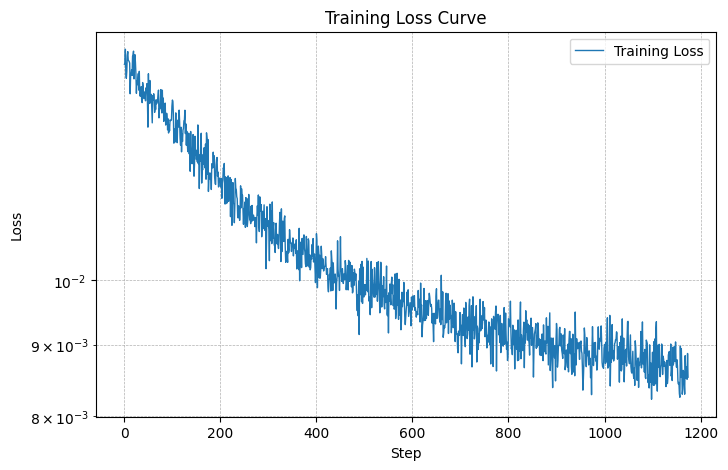

In [165]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", linewidth=1)
plt.yscale("log")  # Log scale for better visualization
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

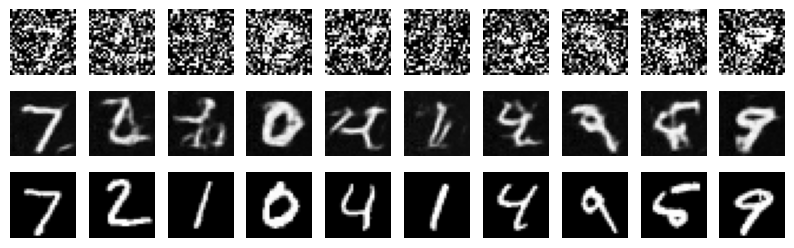

In [168]:
# Get a batch of test images
model.eval()
test_loader = DataLoader(NoisyMNISTDataset(train=False, noise_std=0.9), batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for z, x in test_loader:
        z, x = z.to(device), x.to(device)
        x_pred = model(z)  # Denoised output
        break  # Take only one batch for visualization

# Convert to numpy for visualization
z = z.cpu().numpy()
x_pred = x_pred.cpu().numpy()
x = x.cpu().numpy()

# Plot noisy input, denoised output, and ground truth
fig, axes = plt.subplots(3, 10, figsize=(10, 3))

for i in range(10):
    axes[0, i].imshow(z[i, 0], cmap="gray")  # Noisy input
    axes[1, i].imshow(x_pred[i, 0], cmap="gray")  # Denoised output
    axes[2, i].imshow(x[i, 0], cmap="gray")  # Ground truth

    axes[0, i].axis("off")
    axes[1, i].axis("off")
    axes[2, i].axis("off")

axes[0, 0].set_ylabel("Noisy Input")
axes[1, 0].set_ylabel("Denoised Output")
axes[2, 0].set_ylabel("Ground Truth")

plt.show()


# Part 2: Flow Matching

## Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        raise NotImplementedError()

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [ ]:
def fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def fm__sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return fpm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


### Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        raise NotImplementedError()

In [ ]:
def fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )